<a href="https://colab.research.google.com/github/dsabljic/Home-Price-Prediction/blob/master/Housing_Price_Prediction_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Housing Price Prediction Data](https://www.kaggle.com/datasets/muhammadbinimran/housing-price-prediction-data)

1. **SquareFeet (Kvadratni metri)** - broj kvadratnih metara nekretnine. Tip varijable: cijeli broj (int).
2. **Bedrooms (Spavaće sobe)** - broj spavaćih soba u nekretnini. Tip varijable: cijeli broj (int).
3. **Bathrooms (Kupaonice)** -  broj kupaonica u nekretnini. Tip varijable: cijeli broj (int).
4. **Neighborhood (Susjedstvo)** - ime susjedstva gdje se nekretnina nalazi (Urban, Suburb, Rural). Tip varijable: tekst (string).
5. **YearBuilt (Godina izgradnje)** - godina kada je nekretnina izgrađena. Tip varijable: cijeli broj (int).
6. **Price (Cijena)** - tržišna cijena nekretnine. Tip varijable: decimalni broj (float).

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway
from scipy.stats import skew

import random

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             explained_variance_score, confusion_matrix,
                             classification_report, r2_score)

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError

from multiprocessing import get_context, Pool

In [201]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/datasets/master/housing_price_dataset.csv')
df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [202]:
df.shape

(50000, 6)

In [203]:
df.columns

Index(['SquareFeet', 'Bedrooms', 'Bathrooms', 'Neighborhood', 'YearBuilt',
       'Price'],
      dtype='object')

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


In [205]:
pd.set_option('display.max_columns', None)
df.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


In [206]:
numerical_columns = df.select_dtypes(include=['number'])
categorical_columns = df.select_dtypes(include=['object'])

In [207]:
print(f'Broj numerickih varijabli: {len(numerical_columns.columns)}')
print(f'Broj kategorickih varijabli: {len(categorical_columns.columns)}')

Broj numerickih varijabli: 5
Broj kategorickih varijabli: 1


In [208]:
def highly_correlated(correlation_matrix, target_variable, threshold):

    relevant_features = correlation_matrix[target_variable].apply(abs)
    high_corr_features = relevant_features[relevant_features > threshold].index.tolist()

    high_corr_features.remove(target_variable)

    return high_corr_features

correlation_matrix = numerical_columns.corr()
correlated_vars = highly_correlated(correlation_matrix, 'Price', .3)
correlated_vars

['SquareFeet']

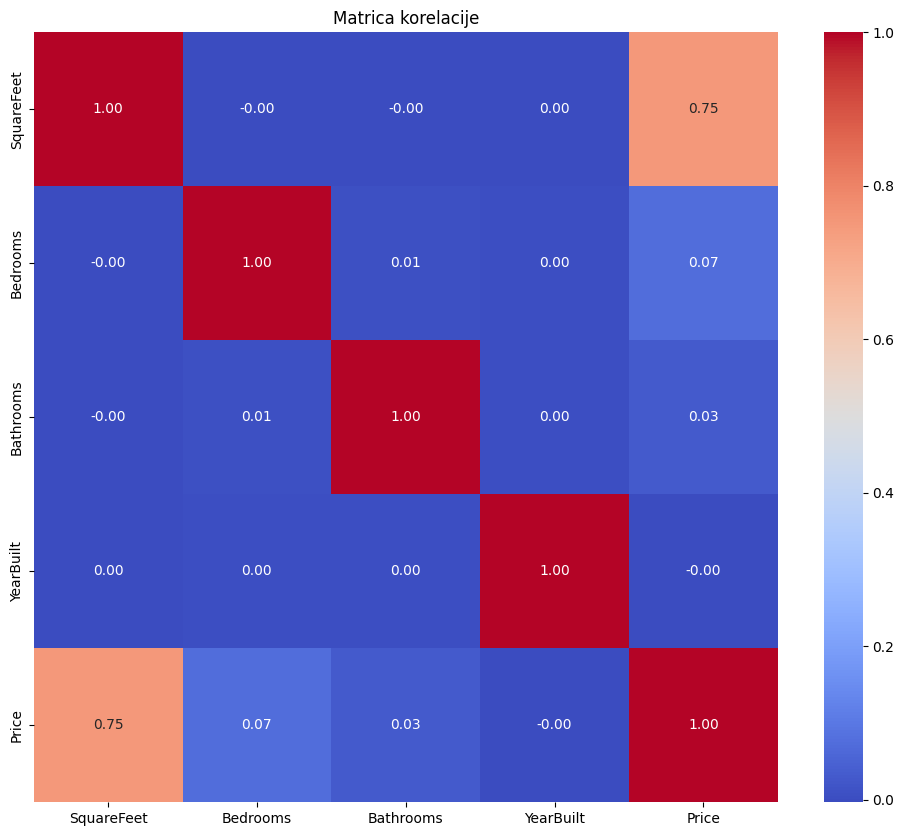

In [209]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrica korelacije')
plt.show()

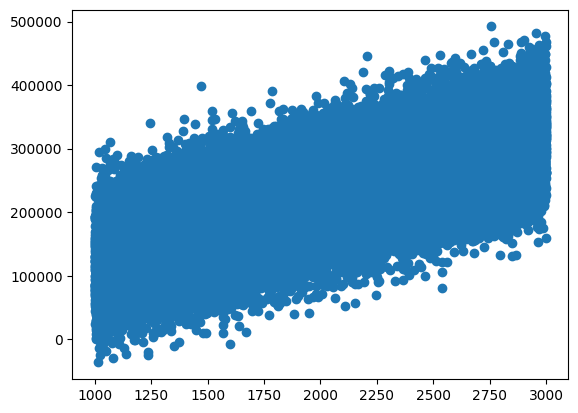

In [210]:
plt.scatter(df.SquareFeet, df.Price)

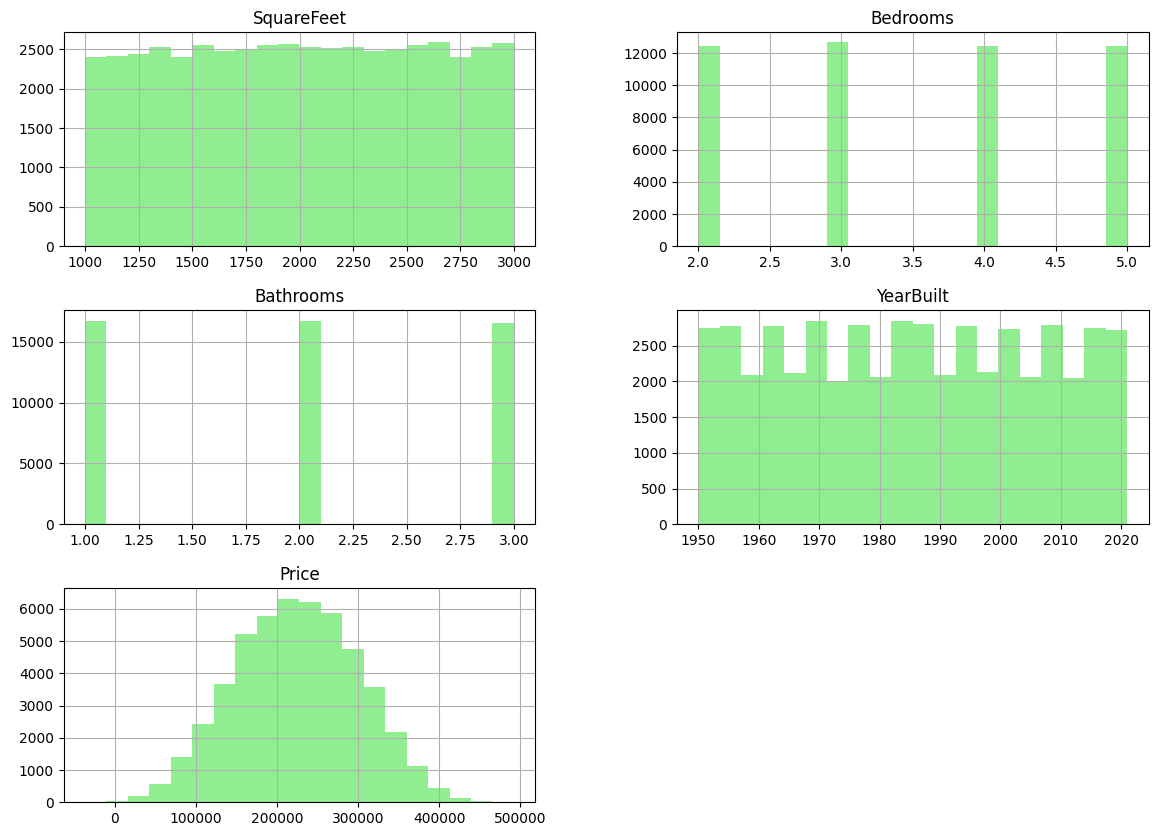

In [211]:
df.hist(bins=20, figsize=(14,10), color='lightgreen')
plt.show()

In [212]:
def categorical_descriptive_stats(df, categorical_columns):

    stats_list = []

    for col in categorical_columns:

        count = df[col].count()

        frequency = df[col].value_counts()

        mode = frequency.idxmax()
        mode_freq = frequency.max()
        mode_pct = (mode_freq / count) * 100

        cardinality = df[col].nunique()

        second_mode = 'N/A'
        second_mode_freq = 'N/A'
        second_mode_pct = 'N/A'
        if len(frequency) > 1 and frequency.iloc[0] != frequency.iloc[1]:
            second_mode = frequency.index[1]
            second_mode_freq = frequency.iloc[1]
            second_mode_pct = (second_mode_freq / count) * 100

        stats_dict = {
            'Feature': col,
            'Count': count,
            '% Miss.': (1 - (count / df.shape[0])) * 100,
            'Card.': cardinality,
            'Mode': mode,
            'Mode Freq.': mode_freq,
            'Mode %': mode_pct,
            '2nd Mode': second_mode,
            '2nd Mode Freq.': second_mode_freq,
            '2nd Mode %': second_mode_pct
        }
        stats_list.append(stats_dict)

    stats_df = pd.DataFrame(stats_list)
    stats_df.set_index('Feature', inplace = True)

    return stats_df

In [213]:
categorical_descriptive_stats(df, ['Neighborhood']).T

Feature,Neighborhood
Count,50000
% Miss.,0.0
Card.,3
Mode,Suburb
Mode Freq.,16721
Mode %,33.442
2nd Mode,Rural
2nd Mode Freq.,16676
2nd Mode %,33.352


In [214]:
def plot_categorical_distributions(df, categorical_columns, filename=None):

    num_rows = np.ceil(len(categorical_columns) / 3).astype(int)

    plt.figure(figsize=(20, 5 * num_rows))

    for i, col in enumerate(categorical_columns, 1):
        plt.subplot(num_rows, 3, i)
        sns.countplot(x=df[col], color='skyblue')

        mode_val = df[col].mode()[0]

        plt.title(f'Histogram of {col}')
        plt.xlabel(f'Mode: {mode_val}')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)

    plt.tight_layout()

    if filename:
        plt.savefig(filename)
        plt.close()
        return filename
    else:
        plt.show()

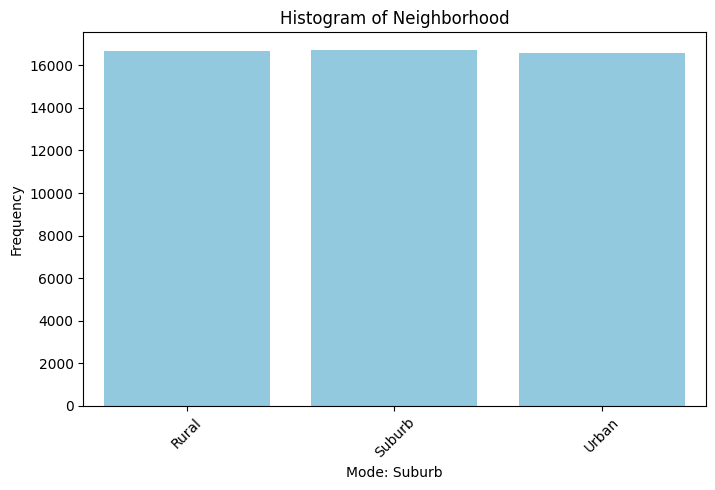

In [215]:
plot_categorical_distributions(df, ['Neighborhood'])

In [216]:
df.Neighborhood.value_counts()

Neighborhood
Suburb    16721
Rural     16676
Urban     16603
Name: count, dtype: int64

In [217]:
df.isna().sum()

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64

## Provjera multikolinearnosti

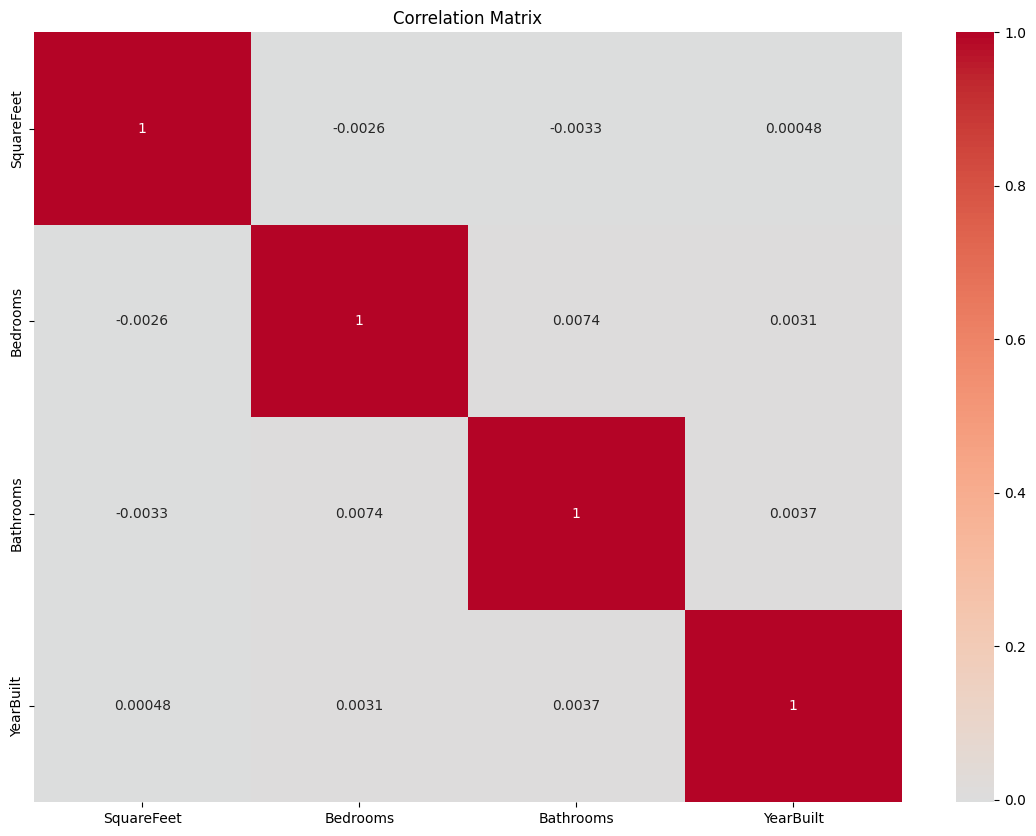

In [218]:
numeric_df = df.select_dtypes(include=[np.number])
numeric_df.drop('Price', axis = 1, inplace = True)

correlation_matrix_numeric = numeric_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

threshold = 0.75
highly_correlated_pairs = []

for i in range(correlation_matrix_numeric.shape[0]):
    for j in range(i):
        if abs(correlation_matrix_numeric.iloc[i, j]) > threshold:
            pair = (correlation_matrix_numeric.index[i], correlation_matrix_numeric.columns[j])
            highly_correlated_pairs.append(pair)

## Čišćenje podataka

### Nedostajuće vrijednosti

In [219]:
pd.DataFrame(df.isna().sum(), columns = ['Missing'])

,Missing
SquareFeet,0
Bedrooms,0
Bathrooms,0
Neighborhood,0
YearBuilt,0
Price,0


### Stršila

In [220]:
def create_boxplots(df, exclude_col='day_of_week', export_png=False, filename='boxplot.png'):
    if exclude_col in df.columns:
        numeric_cols = df.drop(columns=[exclude_col]).select_dtypes(include=[np.number])
    else:
        numeric_cols = df.select_dtypes(include=[np.number])

    num_cols = numeric_cols.shape[1]

    num_rows = (num_cols + 1) // 2

    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.ravel()

    for i, col in enumerate(numeric_cols.columns):
        Q1 = numeric_cols[col].quantile(0.25)
        Q3 = numeric_cols[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = numeric_cols[col][(numeric_cols[col] < lower_bound) | (numeric_cols[col] > upper_bound)]

        axes[i].boxplot(numeric_cols[col].dropna(), vert=True, patch_artist=True)
        axes[i].set_title(col)
        axes[i].set_xlabel(f'Outliers: {len(outliers)}')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if export_png:
        plt.savefig(filename)
        plt.close()
        return filename

    plt.show()

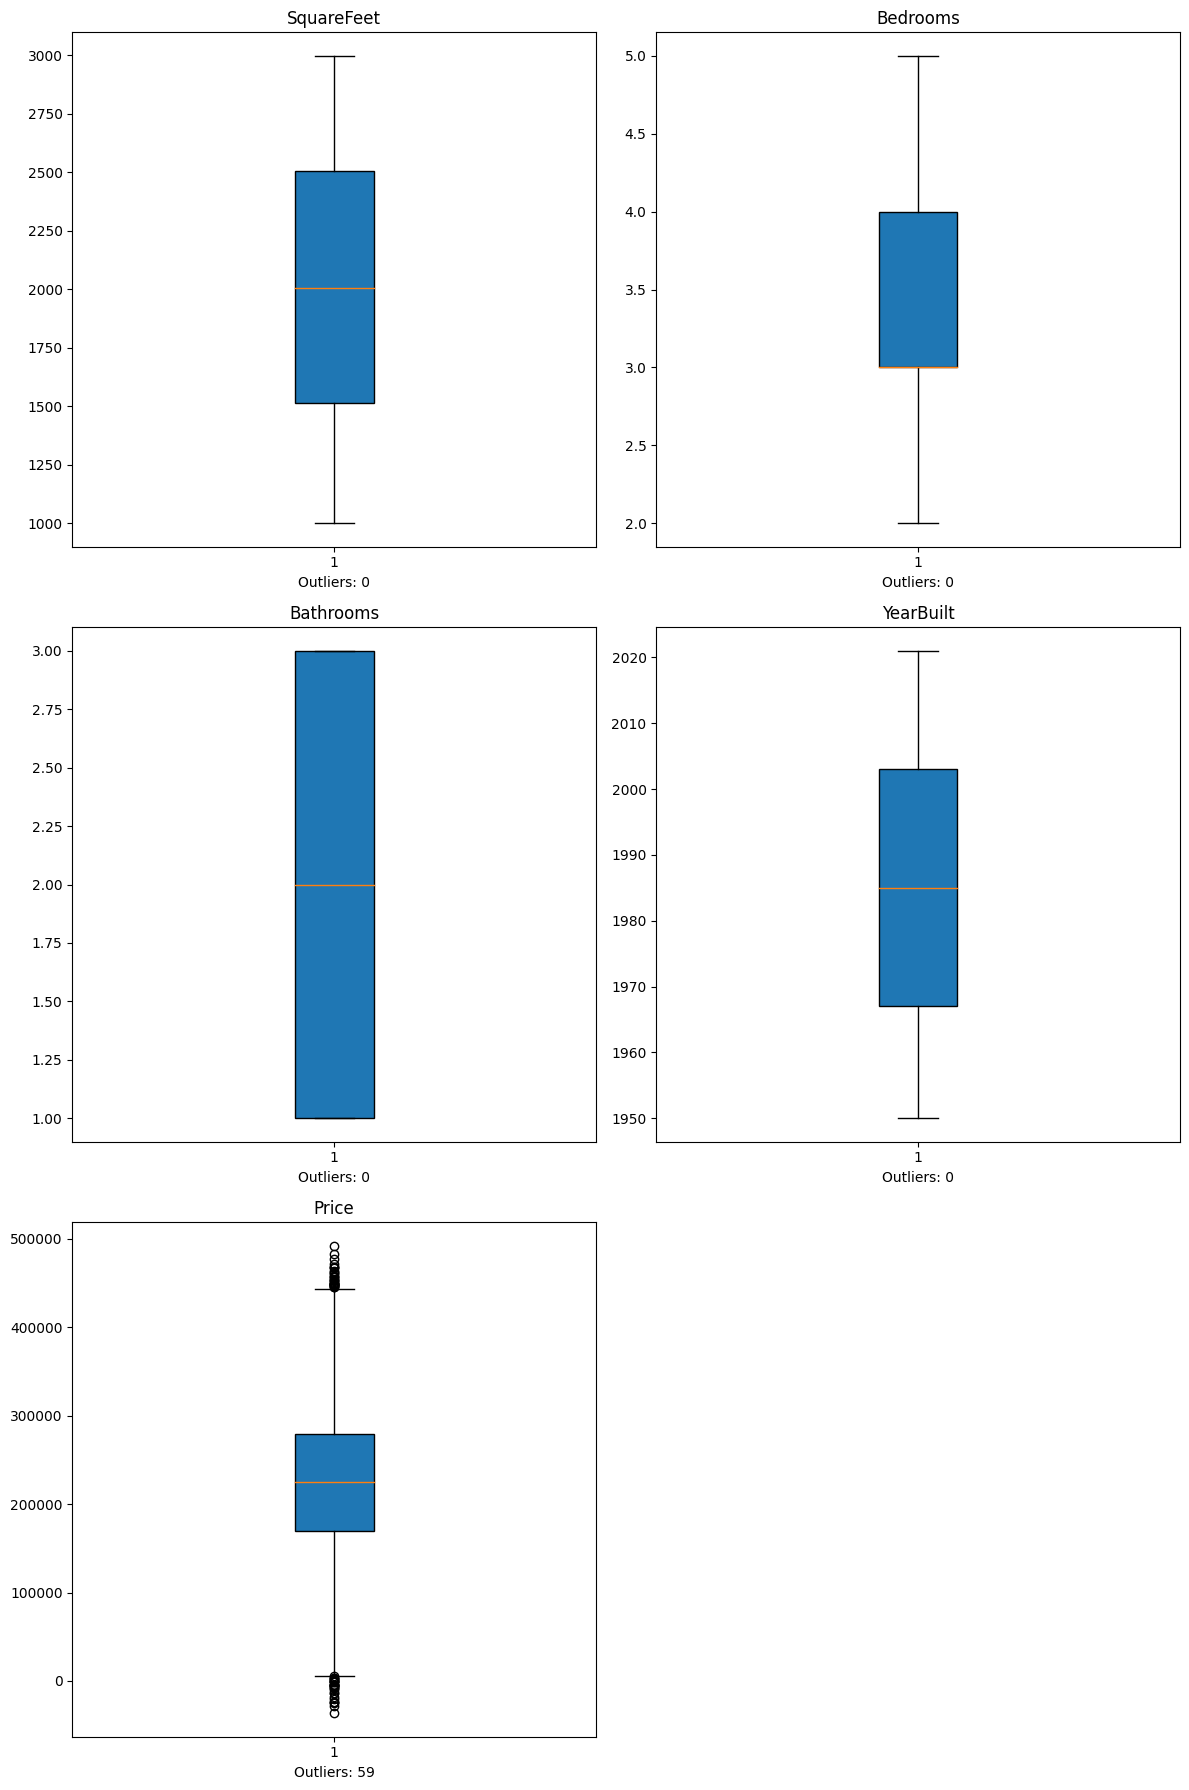

In [221]:
create_boxplots(df)

In [222]:
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return lower_bound, upper_bound, outliers

In [223]:
def get_outlier_count(df):
  numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
  outliers_dict = {col: identify_outliers(df, col)[2] for col in numeric_columns}

  outliers_summary = {col: len(outliers_dict[col]) for col in numeric_columns}
  return outliers_summary

In [224]:
get_outlier_count(df)

{'SquareFeet': 0, 'Bedrooms': 0, 'Bathrooms': 0, 'YearBuilt': 0, 'Price': 59}

In [225]:
df.Price.describe()['min']

-36588.16539749279

In [226]:
len(df[df['Price'] <= 0])

22

In [227]:
df = df[df['Price'] > 0]

In [228]:
df.shape

(49978, 6)

In [229]:
lb, ub, outliers = identify_outliers(df, 'Price')

In [230]:
lb, ub

(5924.978392378485, 443478.33502565237)

In [231]:
df = df[df['Price'] > lb]
df = df[df['Price'] < ub]

In [232]:
get_outlier_count(df)

{'SquareFeet': 0, 'Bedrooms': 0, 'Bathrooms': 0, 'YearBuilt': 0, 'Price': 1}

In [233]:
df.shape

(49941, 6)

In [234]:
df.Price.describe()

count     49941.000000
mean     224822.916361
std       75762.867779
min        6124.032174
25%      170000.830619
50%      225051.077588
75%      279320.164453
max      443335.494338
Name: Price, dtype: float64

In [235]:
df.drop(df.Price.idxmax(), inplace=True)

In [236]:
df.shape

(49940, 6)

## Transformacije varijabli

In [237]:
encoder = OneHotEncoder(sparse=False)
neighborhood_encoded = encoder.fit_transform(df[['Neighborhood']])

neighborhood_encoded_df = pd.DataFrame(neighborhood_encoded, columns=encoder.get_feature_names_out(['Neighborhood']))
df = pd.concat([df.reset_index(drop=True), neighborhood_encoded_df], axis=1)

df = df.drop('Neighborhood', axis=1)

df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price,Neighborhood_Rural,Neighborhood_Suburb,Neighborhood_Urban
0,2126,4,1,1969,215355.283618,1.0,0.0,0.0
1,2459,3,2,1980,195014.221626,1.0,0.0,0.0
2,1860,2,1,1970,306891.012076,0.0,1.0,0.0
3,2294,2,1,1996,206786.787153,0.0,0.0,1.0
4,2130,5,2,2001,272436.239065,0.0,1.0,0.0


In [258]:
X, y = df.drop('Price', axis=1), df.Price

In [259]:
X.head()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Neighborhood_Rural,Neighborhood_Suburb,Neighborhood_Urban
0,2126,4,1,1969,1.0,0.0,0.0
1,2459,3,2,1980,1.0,0.0,0.0
2,1860,2,1,1970,0.0,1.0,0.0
3,2294,2,1,1996,0.0,0.0,1.0
4,2130,5,2,2001,0.0,1.0,0.0


In [260]:
y.head()

0    215355.283618
1    195014.221626
2    306891.012076
3    206786.787153
4    272436.239065
Name: Price, dtype: float64

## Implementacija modela

In [261]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [262]:
numeric_columns = X.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns = numeric_columns[:4]
numeric_columns

['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt']

In [263]:
scaler = MinMaxScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

In [264]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [265]:
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    # Dropout(0.3),
    # Dense(64, activation='relu'),
    # # Dropout(0.2),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.001)

model.compile(
    loss='mean_squared_error',
    optimizer=optimizer,
    metrics=[MeanSquaredError(), MeanAbsoluteError(), r_squared]
)

model.summary()

Model: "sequential_207"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_659 (Dense)           (None, 8)                 64        
                                                                 
 dense_660 (Dense)           (None, 1)                 9         
                                                                 
Total params: 73 (292.00 Byte)
Trainable params: 73 (292.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [266]:
# dir struktura za spremanje modela
!mkdir training_1
!touch training_1/cp.ckpt

mkdir: cannot create directory ‘training_1’: File exists


In [267]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

checkpoint_path = "training_1/cp.ckpt"

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_best_only=True,
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)

Epoch 1/100
934/937 [============================>.] - ETA: 0s - loss: 0.0462 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1562 - r_squared: -0.6359
Epoch 1: val_loss improved from inf to 0.01620, saving model to training_1/cp.ckpt
937/937 [==============================] - 6s 5ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1560 - r_squared: -0.6328 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1015 - val_r_squared: 0.4349
Epoch 2/100
935/937 [============================>.] - ETA: 0s - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0969 - r_squared: 0.4810
Epoch 2: val_loss improved from 0.01620 to 0.01421, saving model to training_1/cp.ckpt
937/937 [==============================] - 5s 5ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0969 - r_squared: 0.4814 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0954 - val_r_squared: 0.5

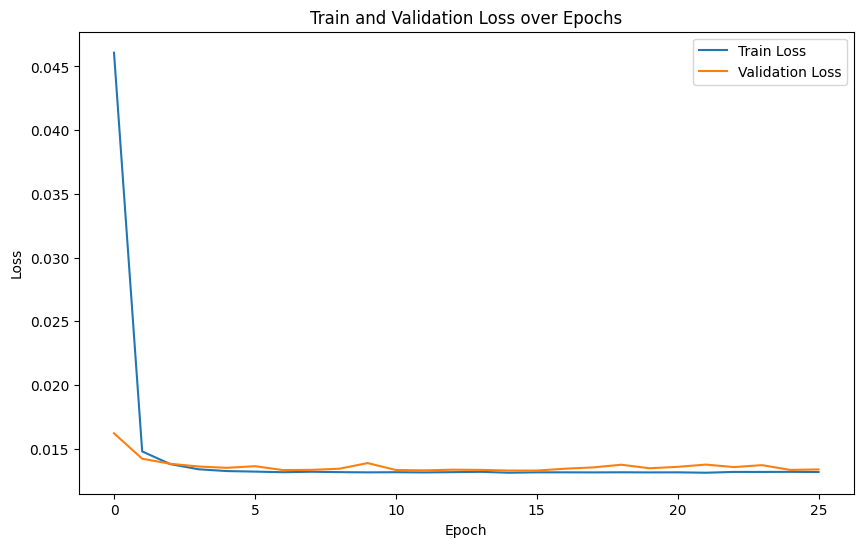

In [268]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

In [269]:
model_best = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    # Dropout(0.3),
    # Dense(64, activation='relu'),
    # # Dropout(0.2),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.001)

model_best.compile(
    loss='mean_squared_error',
    optimizer=optimizer,
    metrics=[MeanSquaredError(), MeanAbsoluteError(), r_squared]
)

model_best.load_weights(checkpoint_path)

313/313 [==============================] - 0s 1ms/step
MSE: 2498373234.925803
MAE: 40130.3426450244
R^2: 0.5675209304411705


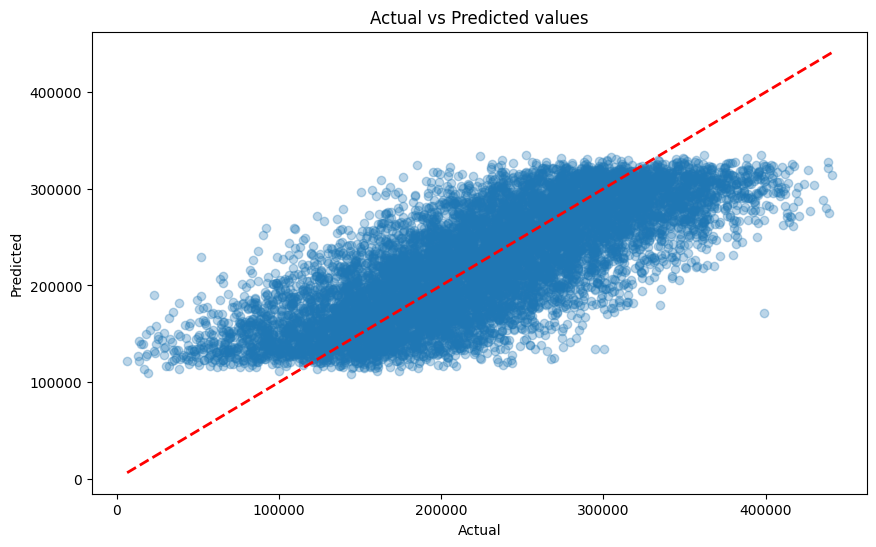

In [270]:
y_test_pred_scaled = model_best.predict(X_test)

y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled).flatten()
y_test_original = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_test_original, y_test_pred)
mae = mean_absolute_error(y_test_original, y_test_pred)
r2 = r2_score(y_test_original, y_test_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_test_pred, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted values')
plt.show()